# Clustering

This notebook uses K-means and agglomerative heirarchical clustering algorithms to cluster census tracts in the Boston area based on percentage change between 2000 and 2010 across a set of variables from the census.

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import pandas as pd
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
import numpy as np

from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import sys
sys.path.append('../')
import Clustering_helper_functions as helper

In [3]:
# import full and sample count csv files
df = pd.read_csv('../samplecount_final.csv',index_col=0)
df2 = pd.read_csv('../fullcount_final.csv',index_col=0)

In [4]:
# pre-processing:
# subset the dataframe to include tractid and percentage change columns only (we aren't clustering on the 
# data from 2000 or 2010, but instead using the % change b/w years)
df_tract=df.iloc[:,0:1]
df_PC = df.iloc[:,38:]
df_PC_subset = df_tract.merge(df_PC,left_index=True,right_index=True)

# do the same to the sample df
df2_tract=df2.iloc[:,0:1]
df2_PC = df2.iloc[:,48:]
df2_PC_subset = df2_tract.merge(df2_PC,left_index=True,right_index=True)

# merge the 2
df_PC_subset_joined = df_PC_subset.merge(df2_PC_subset,how='outer',on='tractid')

# reset index to be tract id
df_PC_subset_joined.set_index('tractid',inplace=True)

# scale the data for clustering
df_scaled=helper.scale_df(df_PC_subset_joined)

## K-means clustering

### 1. Using all variables

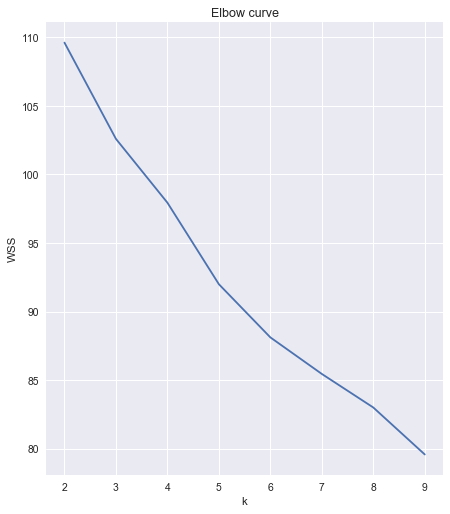

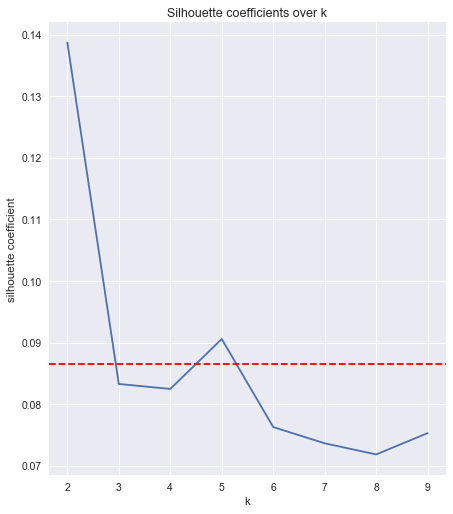

In [4]:
# run elbow and Silhouette methods to determine optimal k
helper.check_k_means(df_scaled)

In [5]:
# looks like k=5 might be appropriate, so let's try!

# fit the model with the scaled dataframe
model1 = helper.fit_k_means(5,df_scaled)

# create a new dataframe showing the clusters and scaled data
cluster_df1 = helper.create_cluster_df(model1,df_scaled)

# observe the breakdown of clusters
print("Distribution of clusters:")
print(cluster_df1['cluster'].value_counts())

print(f"Silhouette score: {silhouette_score(df_scaled.values, cluster_df1['cluster'])}")

Distribution of clusters:
1    78
0    54
2    32
4    26
3     1
Name: cluster, dtype: int64
Silhouette score: 0.06927940546414996


In [ ]:
# Silhouette score is relatively low - let's try on a subset of variables typically looked at for gentrification

### 2. Using subset of variables

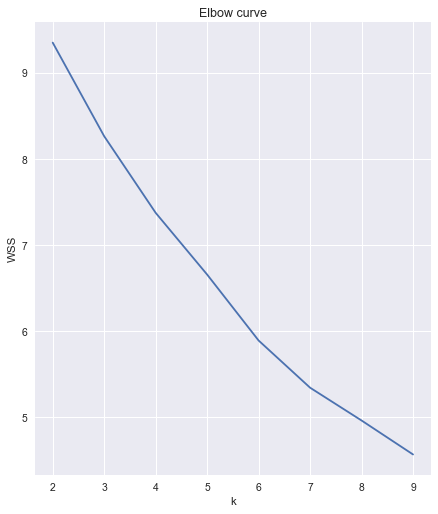

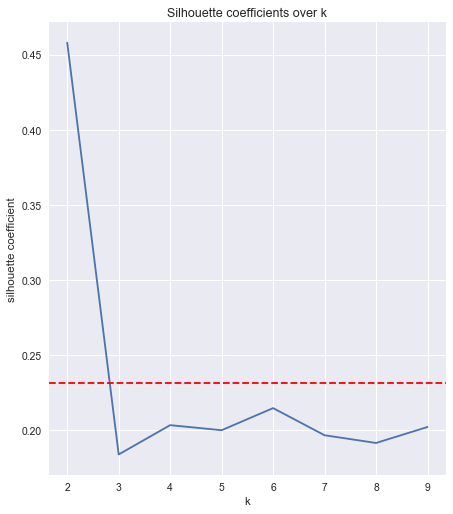

In [6]:
# traditional measures of gentrification (these variables represent % change median income, % change median
# home value, # change median rent, % change in owner occupied housing, % change in non white pop, % change in
# pop with 4 yr college degree or more)
df_subset_scaled = df_scaled[['HINC00_PC','MHMVAL00_PC','MRENT00_PC','percent_owneroccupied_00_PC',
                              'percent_non-white00_PC','percent_4yrcollege_degree_ormore_PC']]

helper.check_k_means(df_subset_scaled)

In [12]:
# lets try k=4 and k=6

# fit the model with the scaled dataframe
model2 = helper.fit_k_means(4,df_subset_scaled)

# create a new dataframe showing the clusters and scaled data
cluster_df2 = helper.create_cluster_df(model2,df_subset_scaled)

# observe the breakdown of clusters
print("Distribution of clusters:")
print(cluster_df2['cluster'].value_counts())

print(f"Silhouette score: {silhouette_score(df_subset_scaled.values, cluster_df2['cluster'])}")
      
      # silhouette score went up!

Distribution of clusters:
0    81
1    78
2    26
3     6
Name: cluster, dtype: int64
Silhouette score: 0.2011049044804334


In [11]:
# fit the model with the scaled dataframe
model2 = helper.fit_k_means(6,df_subset_scaled)

# create a new dataframe showing the clusters and scaled data
cluster_df2 = helper.create_cluster_df(model2,df_subset_scaled)

# observe the breakdown of clusters
print("Distribution of clusters:")
print(cluster_df2['cluster'].value_counts())

print(f"Silhouette score: {silhouette_score(df_subset_scaled.values, cluster_df2['cluster'])}")
      
      # looks like group 3 from k=4 gets split up into 3 individual clusters with k=6,
      # however silhouette score doesn't change much
      # perhaps 3 clusters works well, with 1 "overflow" cluster 

Distribution of clusters:
0    79
3    78
1    26
5     6
4     1
2     1
Name: cluster, dtype: int64
Silhouette score: 0.20921307593935368


#### Optimize centroid location

In [ ]:
# with k-means, the intial location of the centroids can greatly influence the clusters
# so we will optimize the starting location

In [41]:
# set variables for finding best centroids
sample_size = 0.20
random_state = 42
n_clusters = 4     # k
n_iterations = 3          # n
n_attempts = 10      # m

# here we take an initial sample of our dataframe and then iteratively perform k-means
# then we will perform k-means on full dataset using clusters found from sample
data_sample = df_subset_scaled.sample(frac=sample_size)

In [42]:
data_sample.shape

(38, 6)

In [43]:
from sklearn.cluster import KMeans
best_cents = best_centroids(.3,42,4,3,10)


Centroid attempt:  0
Iteration:  0
Inertia: 2.8482912915288066
Centroids: [[0.34939096 0.47509529 0.39340451 0.27408319 0.19404423 0.49122438]
 [0.21569927 0.45428854 0.32030955 0.23317454 0.10056058 0.23852245]
 [0.340144   0.47111643 0.46497749 0.25516644 0.09645492 0.3006096 ]
 [0.21565181 0.39378584 0.43714535 0.3012821  0.10147538 0.23014301]]
Iteration:  1
Inertia: 2.6583063469248023
Centroids: [[0.34939083 0.47698702 0.38489184 0.2811635  0.19522749 0.51256259]
 [0.21599409 0.45926961 0.34941219 0.23589816 0.10333239 0.23602808]
 [0.34102475 0.47032429 0.46343076 0.25258498 0.10501665 0.30555402]
 [0.21453352 0.30325077 0.47257883 0.37320615 0.09259463 0.22906741]]
Iteration:  2
Inertia: 2.325216073369167
Centroids: [[0.35259202 0.48123784 0.38397905 0.29143008 0.18178099 0.54423236]
 [0.22033446 0.45244011 0.36913014 0.23037832 0.10257564 0.2351209 ]
 [0.34409326 0.46955659 0.46057337 0.25212054 0.11946337 0.31775565]
 [0.24599915 0.15016052 0.50107496 0.63632206 0.09935085 0.

In [35]:
def best_centroids(sample_size, random_state, n_clusters, n_iterations, n_attempts):
    """
    best_centroids()
    Params:
        sample_size:
        random_state:
        n_clusters:
        n_iterations:
        n_attempts:
    Returns:
    
    """
    # create sample of dataframe
    data_sample = df_subset_scaled.sample(frac=sample_size, random_state=random_state, replace=False)
    
    final_cents = []
    final_inert = []

# each iteration randomly initializes k centroids and performs n interations of k-means
    for sample in range(n_attempts):
        print('\nCentroid attempt: ', sample)
        km = KMeans(n_clusters=n_clusters, init='random', max_iter=1, n_init=1)
        km.fit(data_sample)
        inertia_start = km.inertia_
        intertia_end = 0
        cents = km.cluster_centers_

        for iter in range(n_iterations):
            km = KMeans(n_clusters=n_clusters, init=cents, max_iter=1, n_init=1)
            km.fit(data_sample)
            print('Iteration: ', iter)
            print('Inertia:', km.inertia_)
            print('Centroids:', km.cluster_centers_)
            inertia_end = km.inertia_
            cents = km.cluster_centers_

        final_cents.append(cents)
        final_inert.append(inertia_end)
        print('Difference between initial and final inertia: ', inertia_start-inertia_end)
    best_cents = final_cents[final_inert.index(min(final_inert))]
    return best_cents

In [44]:
# Get best centroids to use for full clustering (in our case, 
# the metric is the lowest within-cluster sum-of-squares, or inertia).)

best_cents

array([[0.25645812, 0.4549925 , 0.3855985 , 0.23398038, 0.12221521,
        0.25327262],
       [0.34904195, 0.432418  , 0.39966159, 0.37078126, 0.09400424,
        0.57452607],
       [0.36463719, 0.4668916 , 0.51382111, 0.26861771, 0.07264733,
        0.34026095],
       [0.29487777, 0.48792225, 0.37158043, 0.25432432, 1.        ,
        0.20810616]])

In [45]:
km_full = KMeans(n_clusters=4, init=best_cents, max_iter=100, verbose=1, n_init=1).fit(df_subset_scaled)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 7.701738853367988
start iteration
done sorting
end inner loop
Iteration 1, inertia 7.603762130487523
start iteration
done sorting
end inner loop
Iteration 2, inertia 7.558000479343168
start iteration
done sorting
end inner loop
Iteration 3, inertia 7.551360395406634
start iteration
done sorting
end inner loop
Iteration 4, inertia 7.5463597983905295
start iteration
done sorting
end inner loop
Iteration 5, inertia 7.541156195845159
start iteration
done sorting
end inner loop
Iteration 6, inertia 7.540088260802727
start iteration
done sorting
end inner loop
Iteration 7, inertia 7.53892717260045
start iteration
done sorting
end inner loop
Iteration 8, inertia 7.538183555099119
start iteration
done sorting
end inner loop
Iteration 9, inertia 7.538183555099119
center shift 0.000000e+00 within tolerance 1.149723e-06


In [46]:
# create a new dataframe showing the clusters and scaled data
cluster_df2 = helper.create_cluster_df(km_full,df_subset_scaled)

# observe the breakdown of clusters
print("Distribution of clusters:")
print(cluster_df2['cluster'].value_counts())

print(f"Silhouette score: {silhouette_score(df_subset_scaled.values, cluster_df2['cluster'])}")
      
      # silhouette score went up!

Distribution of clusters:
0    82
2    80
1    28
3     1
Name: cluster, dtype: int64
Silhouette score: 0.20017068940357172


In [47]:
## merge this with original df of subset variables to look at summary stats
cluster_df2.set_index('tractid',inplace=True)

In [48]:
cluster_data_df = cluster_df2.merge(df_PC_subset_joined[['HINC00_PC','MHMVAL00_PC','MRENT00_PC','percent_owneroccupied_00_PC','percent_non-white00_PC',
                             'percent_4yrcollege_degree_ormore_PC']],how='outer',on='tractid')


In [51]:
cluster_data_df[cluster_data_df['cluster']==3]

,cluster,HINC00_PC,MHMVAL00_PC,MRENT00_PC,percent_owneroccupied_00_PC,percent_non-white00_PC,percent_4yrcollege_degree_ormore_PC
tractid,,,,,,,
25025040401,3,10.249766,60.474261,10.271589,2.313427,622.412581,-3.834091


## Agglomerative Hierarchical

Bottom up approach - starts with many small clusters then merges them together to create bigger clusters.

### 1. Using all variables

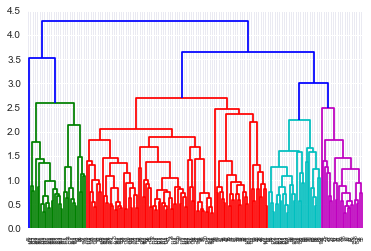

In [12]:
# we've already scaled the dataframe 
# create a dendogram to determine optimal k
dendogram = sch.dendrogram(sch.linkage(df_scaled,method='ward'))

# k = 4

In [13]:
# fit the data
model4 = AgglomerativeClustering(n_clusters=4,linkage='ward')
model4.fit(df_scaled.values)


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=4,
            pooling_func='deprecated')

In [14]:
# create a new dataframe showing the clusters and scaled data
cluster_df4 = helper.create_cluster_df(model4,df_scaled)

# observe the breakdown of clusters
print("Distribution of clusters:")
print(cluster_df4['cluster'].value_counts())

print(f"Silhouette score: {silhouette_score(df_scaled.values, cluster_df4['cluster'])}")
      
# not a great silhouette score, let's try subsetting the df

Distribution of clusters:
2    104
0     54
1     32
3      1
Name: cluster, dtype: int64
Silhouette score: 0.07424592505624232


### 2. Using subset of variables

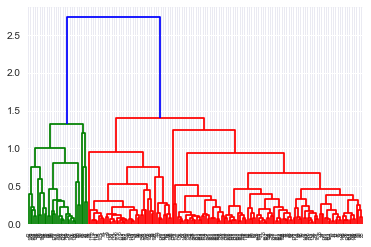

In [15]:
dendogram = sch.dendrogram(sch.linkage(df_subset_scaled,method='ward'))
# k=2 clearly

In [16]:
# fit the data
model5 = AgglomerativeClustering(n_clusters=2,linkage='ward')
model5.fit(df_subset_scaled.values)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func='deprecated')

In [17]:
# create a new dataframe showing the clusters and scaled data
cluster_df5 = helper.create_cluster_df(model5,df_subset_scaled)

# observe the breakdown of clusters
print("Distribution of clusters:")
print(cluster_df5['cluster'].value_counts())

print(f"Silhouette score: {silhouette_score(df_subset_scaled.values, cluster_df5['cluster'])}")
      
      # clearly a higher silhouette score, however, 
      # objective of this project isn't to divide neighborhoods into 2 groups

Distribution of clusters:
0    157
1     34
Name: cluster, dtype: int64
Silhouette score: 0.46146886429059675


## Observing the clusters

In [ ]:
# choose clusters resulting from agglomerative heirarchical
## Observe summary stats for each cluster to identify trends
cluster_data_df.groupby('cluster').describe()

In [ ]:
# For now let's drop cluster 3 because the median home vlaue PC doesn't make sense 
cluster_data_df.drop(25025060700,axis=0,inplace=True)

In [ ]:
# cluster 0: 'gentrified'
# cluster 1: 'low income'
# cluster 2: "stable"
# cluster 3: 'other'

In [ ]:
# what is the baseline? check these stats across all tracts
cluster_data_df.describe()

In [ ]:
def func(x):
    if x == 0:
        return 'Gentrifying'
    elif x==1:
        return 'Becoming more affordable'
    else:
        return 'Remaining costly'

In [ ]:
cluster_data_df['cluster_name']=cluster_data_df['cluster'].apply(func)

In [ ]:
cluster_data_df=cluster_data_df.round(2)

In [ ]:
cluster_data_df.rename(columns={'HINC00_PC':'Percentage_Change_in_Median Household Income',
                                'MHMVCAL00_PC':'Percentage Change in Median Home Value',
                                'MRENT00_PC':'Percentage Change in Median Rent',
                                'MRENT00_PC':'Percentage Change in Median Rent',
                                'percent_owneroccupied_00_PC':'Percentage Change in Owner Occupied Housing',
                                'percent_non-white00_PC':'Percentage Change in Non-White Population',
                                'percent_4yrcollege_degree_ormore_PC':'Percentage Change in Population with 4YR College Degree'},inplace=True)



In [ ]:
cluster_data_df.reset_index(level=0, inplace=True)

In [ ]:
cluster_data_df.to_csv('CSV_files/clusters.csv')